# Analysis of wrf output Uttarakhand 2013

In [1]:
# imports
from __future__ import print_function

from netCDF4 import Dataset
import numpy as np
                                                                                                                                                                                                                                                                    
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib as mpl
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import cartopy.io.shapereader as shpreader

from wrf import (to_np, interplevel, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, ALL_TIMES, CoordPair, vertcross)

In [2]:
%matplotlib inline

In [3]:
from functions import wrfplot

In [4]:
# plotting style
# import seaborn as sns
# Use seaborn style defaults and set default figure size
# plt.style.use('seaborn-pastel')
# sns.set_theme(style="ticks")
plt.style.use(['science', 'notebook'])

In [5]:
# Colormap selection
xr.set_options(cmap_divergent='RdBu', cmap_sequential='YlGnBu')

## Importing data and preparation

In [6]:
dom1 = Dataset("./data/wrfout_d01.nc")
dom2 = Dataset("./data/wrfout_d02.nc")

#### Domain 1

In [7]:
# olr = getvar(dom1, "OLR", timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
# avo = getvar(dom1, "avo", timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
# rvo = (avo - (2*7.2921159*np.sin(20*(np.pi/180)))).resample(Time='D').mean()
# T2 = getvar(dom1, "T2", timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
# td2 = getvar(dom1, "td2", timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
uvmet = getvar(dom1, "uvmet", units='m/s', timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
# uvmet10 = getvar(dom1, "uvmet10", units='m/s', timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
uvmet_wspd_wdir = getvar(dom1, "uvmet_wspd_wdir", units='m/s', timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
# uvmet10_wspd_wdir = getvar(dom1, "uvmet10_wspd_wdir", units='m/s', timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
wspd_wdir = getvar(dom1, "wspd_wdir", units='m/s', timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
# wspd_wdir10 = getvar(dom1, "wspd_wdir10", units='m/s', timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()

In [8]:
# olr2 = getvar(dom2, "OLR", timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
# avo2 = getvar(dom2, "avo", timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
# rvo2 = (avo2 - (2*7.2921159*np.sin(20*(np.pi/180)))).resample(Time='D').mean()
# T2_2 = getvar(dom2, "T2", timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
# td2_2 = getvar(dom2, "td2", timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
uvmet2 = getvar(dom2, "uvmet", units='m/s', timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
# uvmet10_2 = getvar(dom2, "uvmet10", units='m/s', timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
uvmet_wspd_wdir2 = getvar(dom2, "uvmet_wspd_wdir", units='m/s', timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
# uvmet10_wspd_wdir_2 = getvar(dom2, "uvmet10_wspd_wdir", units='m/s', timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
wspd_wdir2 = getvar(dom2, "wspd_wdir", units='m/s', timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
# wspd_wdir10_2 = getvar(dom2, "wspd_wdir10", units='m/s', timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()

In [9]:
# omega = getvar(dom1, "omega", timeidx=ALL_TIMES,method='cat').resample(Time='D').mean()

In [10]:
# omega2 = getvar(dom2, "omega", timeidx=ALL_TIMES,method='cat').resample(Time='D').mean()

In [19]:
# sfroff = getvar(dom1, "SFROFF", timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()

In [20]:
# sfroff2 = getvar(dom2, "SFROFF", timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()

In [17]:
# pw = getvar(dom1, "pw", timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()

In [18]:
# pw2 = getvar(dom2, "pw", timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()

In [11]:
rainc = getvar(dom1, "RAINC", timeidx=ALL_TIMES, method='cat')
rainnc = getvar(dom1, "RAINNC", timeidx=ALL_TIMES, method='cat')
total_precip = rainc + rainnc

In [12]:
rainc2 = getvar(dom2, "RAINC", timeidx=ALL_TIMES, method='cat')
rainnc2 = getvar(dom2, "RAINNC", timeidx=ALL_TIMES, method='cat')
total_precip2 = rainc2 + rainnc2

In [13]:
total_precip = total_precip[::8]

In [14]:
total_precip2 = total_precip2[::12]

In [15]:
precip_rate = total_precip.diff(dim='Time')
precip_rate = precip_rate.transpose('Time', 'south_north', 'west_east')
precip_rate.coords['Time'] = total_precip[:-1].coords['Time']

In [16]:
precip_rate2 = total_precip2.diff(dim='Time')
precip_rate2 = precip_rate2.transpose('Time', 'south_north', 'west_east')
precip_rate2.coords['Time'] = total_precip2[:-1].coords['Time']

In [17]:
# Smooth the sea level pressure since it tends to be noisy near the
# mountains
# smooth_slp = smooth2d(slp, 3, cenweight=4)

In [18]:
# smooth_slp

### Plotting

#### OLR

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

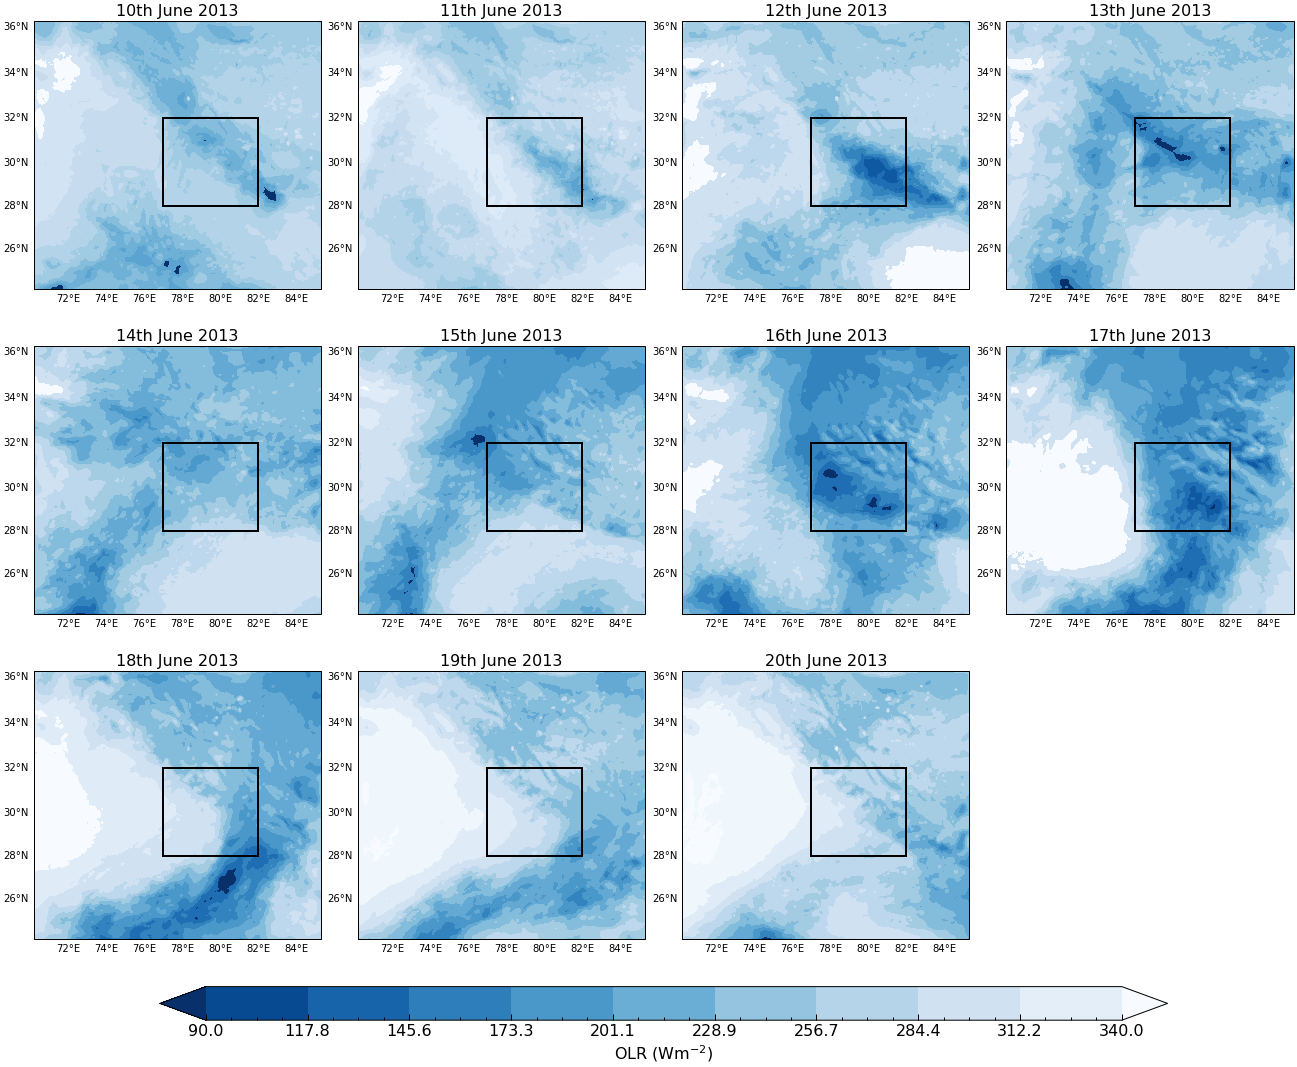

In [26]:
wrfplot.plot_figure(olr2, cmap='Blues_r', levels=10, cbar_label='OLR (Wm$^{-2}$)', domain=2)
plt.savefig('./images/olr2.pdf')

#### T2

/home/aditya/.miniconda/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/aditya/.miniconda/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/aditya/.miniconda/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/aditya/.miniconda/lib/python3.8/site-packages/cartopy/crs.py:825

/home/aditya/.miniconda/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/aditya/.miniconda/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/aditya/.miniconda/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/aditya/.miniconda/lib/python3.8/site-packages/cartopy/crs.py:825

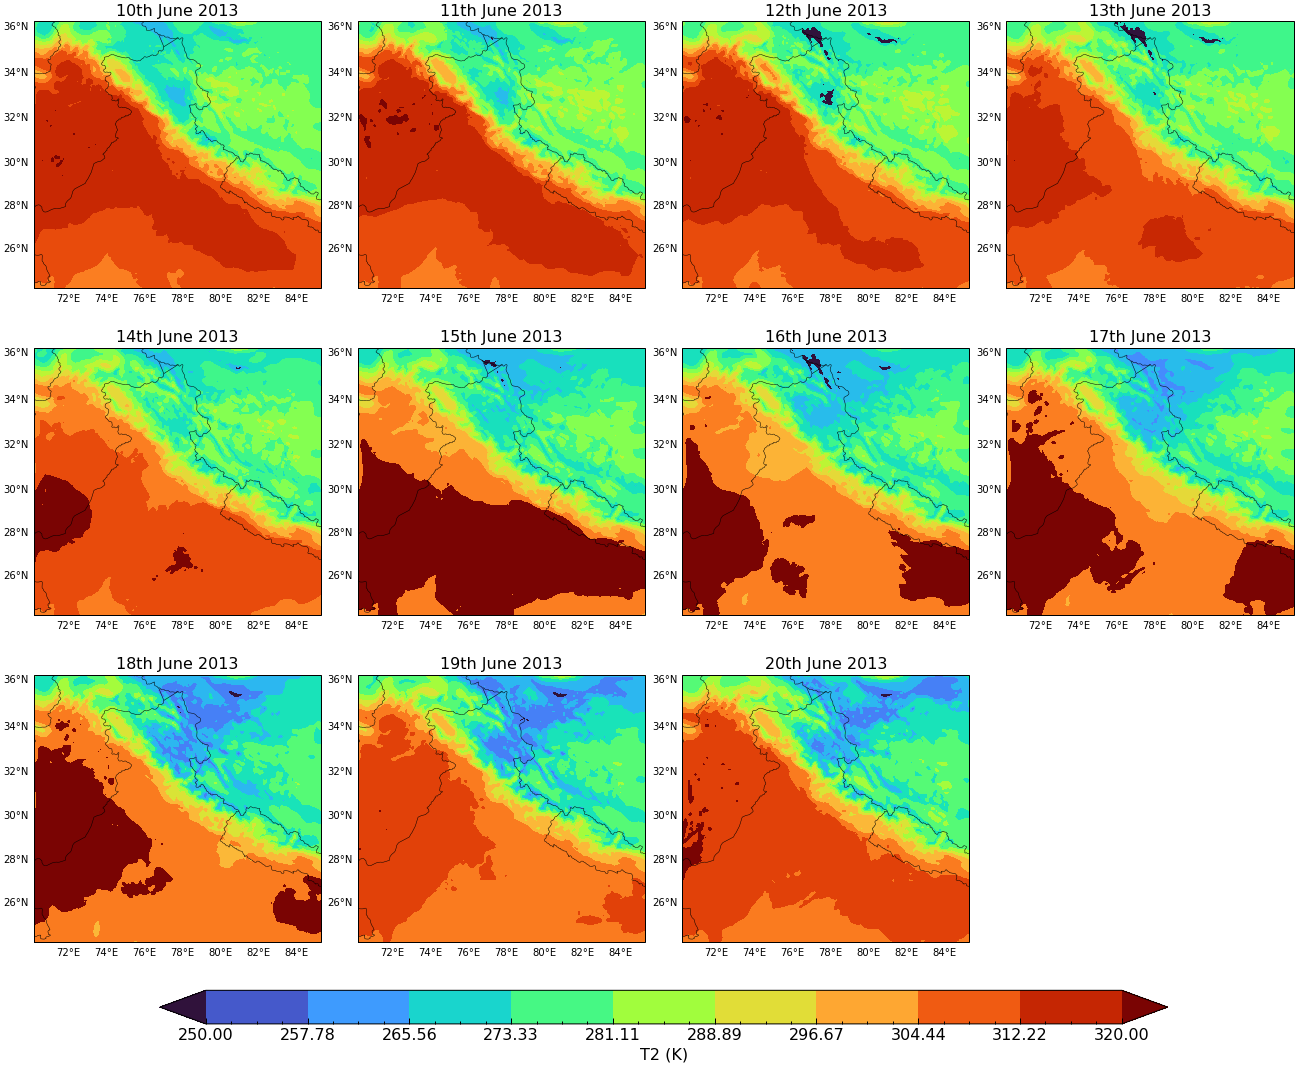

In [26]:
wrfplot.plot_figure(T2_2, cmap='turbo', levels=10, cbar_label='T2 (K)', domain=2)
plt.savefig('./images/t2_2.pdf')

#### Precip rate

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

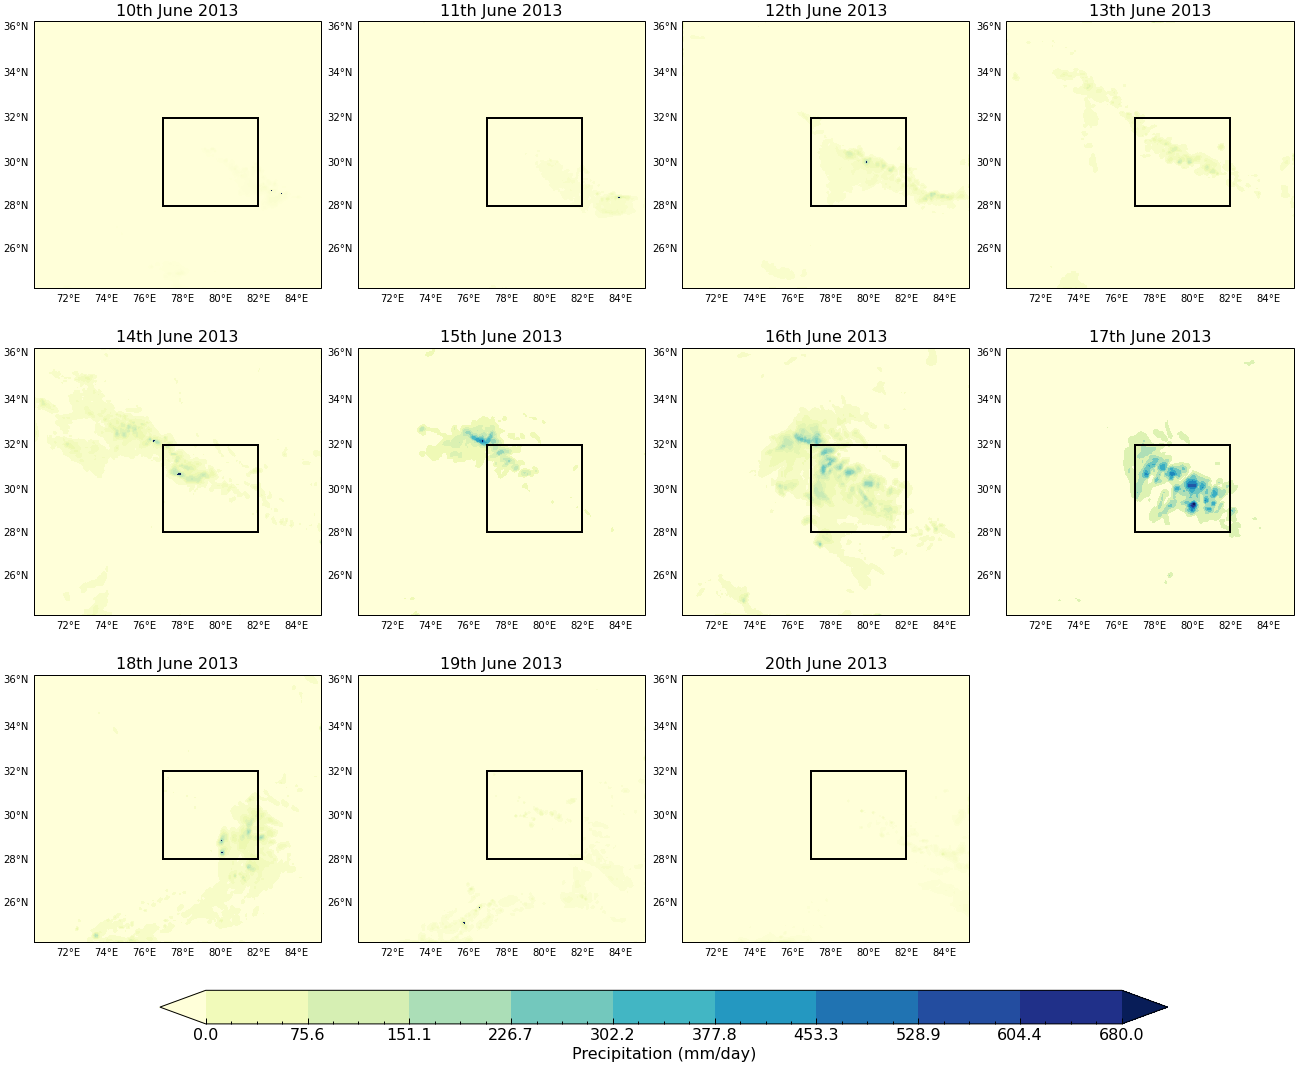

In [28]:
wrfplot.plot_figure(precip_rate2, cmap='YlGnBu', levels=10, cbar_label='Precipitation (mm/day)', domain=2)
plt.savefig('./images/precip2.pdf')

#### Accumulated precip

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

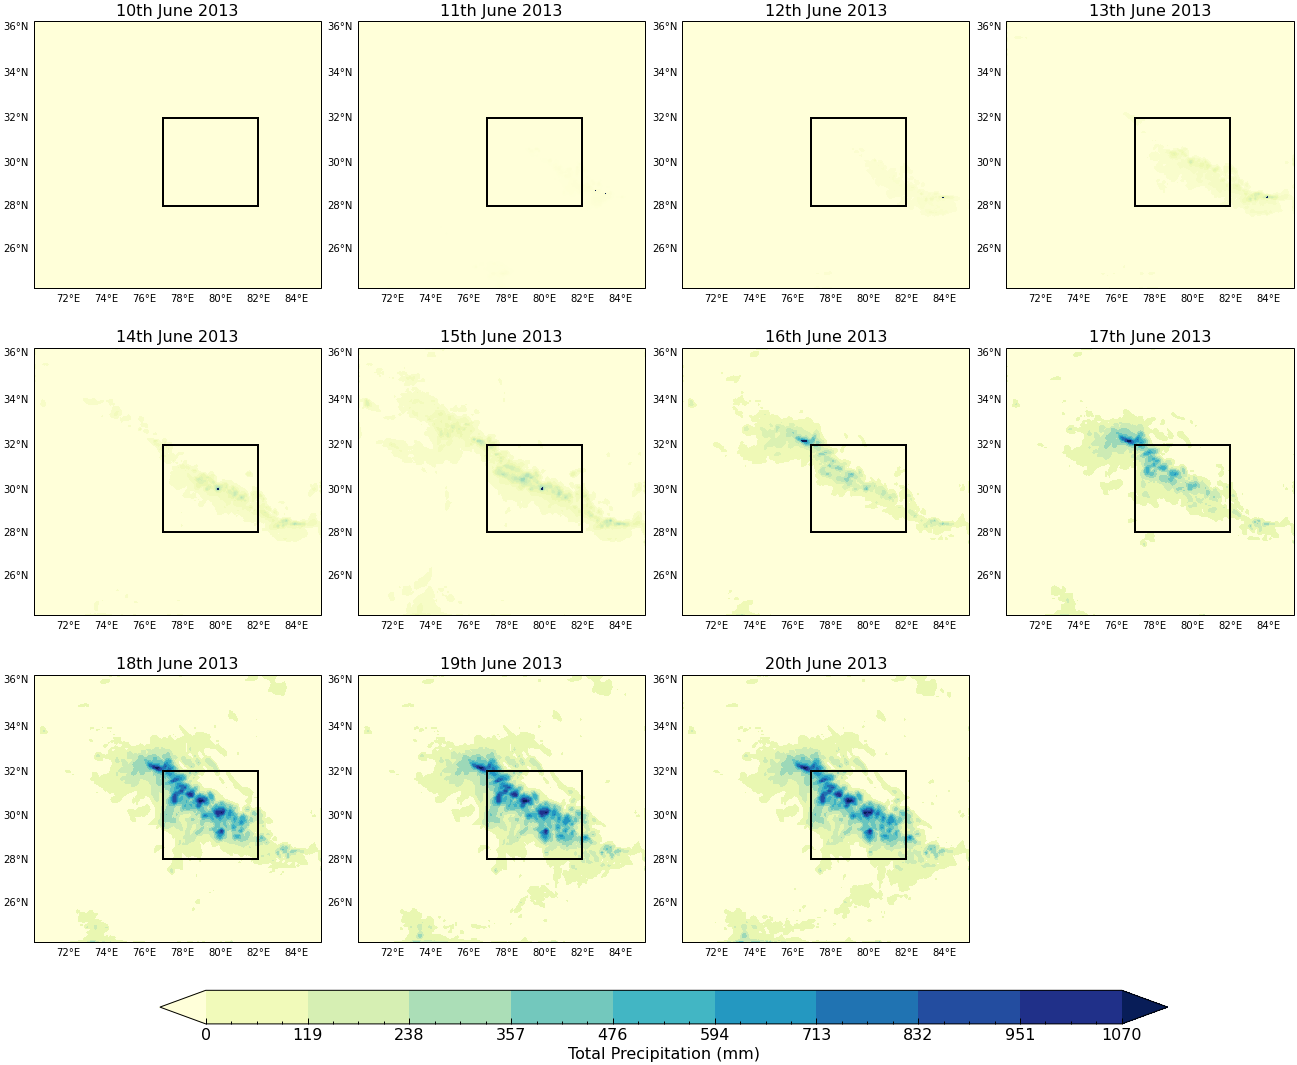

In [30]:
wrfplot.plot_figure(total_precip2, cmap='YlGnBu', levels=10, cbar_label='Total Precipitation (mm)', domain=2)
plt.savefig('./images/total_precip2.pdf')

#### Wind paramneters and vorticity

In [13]:
p = getvar(dom1, "pressure")
u = uvmet[0,:]
v = uvmet[1,:]
wspd = uvmet_wspd_wdir[0,:]
u_850 = interplevel(u, p, 850)
v_850 = interplevel(v, p, 850)
# w_850 = interplevel(wa, p, 850)
wspd_850 = interplevel(wspd, p, 850)
# rvo_850 = interplevel(rvo, p, 850)
# avo_850 = interplevel(avo, p, 850)
# omega_850 = interplevel(omega, p, 850)

In [14]:
p2 = getvar(dom2, "pressure")
u2 = uvmet2[0,:]
v2 = uvmet2[1,:]
wspd2 = uvmet_wspd_wdir2[0,:]
u_850_2 = interplevel(u2, p2, 850)
v_850_2 = interplevel(v2, p2, 850)
# w_850_2 = interplevel(wa2, p2, 850)
wspd_850_2 = interplevel(wspd2, p2, 850)
# rvo_850_2 = interplevel(rvo2, p2, 850)
# avo_850_2 = interplevel(avo2, p2, 850)
# omega_850_2 = interplevel(omega2, p2, 850)

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

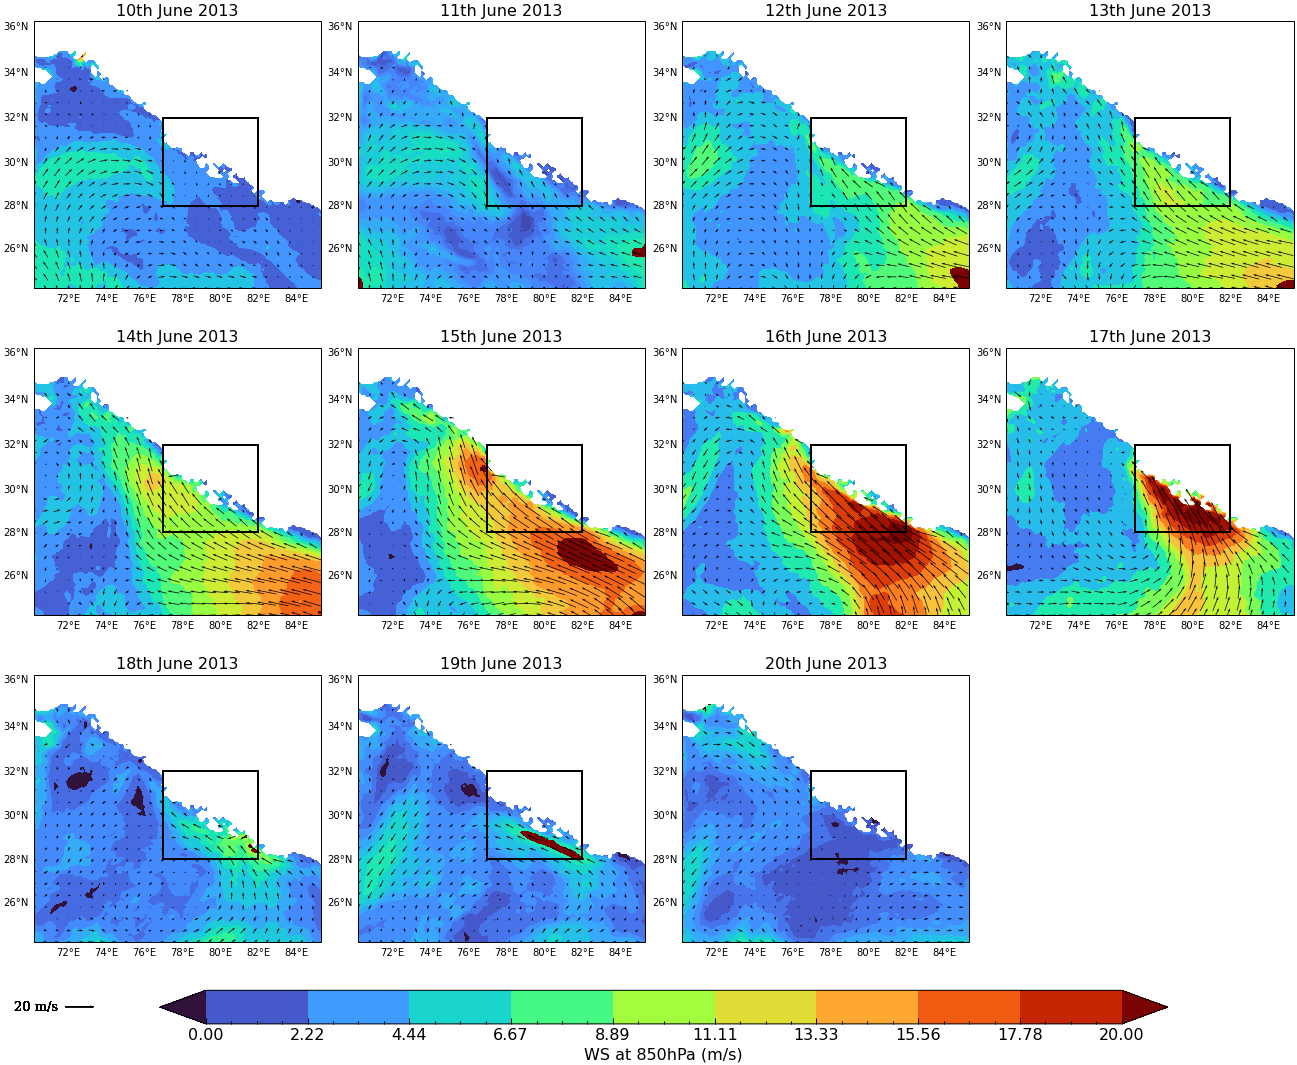

In [45]:
wrfplot.plot_wind(wspd_850_2, u_850_2, v_850_2, cmap='turbo', levels=10, cbar_label='WS at 850hPa (m/s)', method='quiver', domain=2)
plt.savefig('./images/ws850_2.pdf', dpi=300)

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


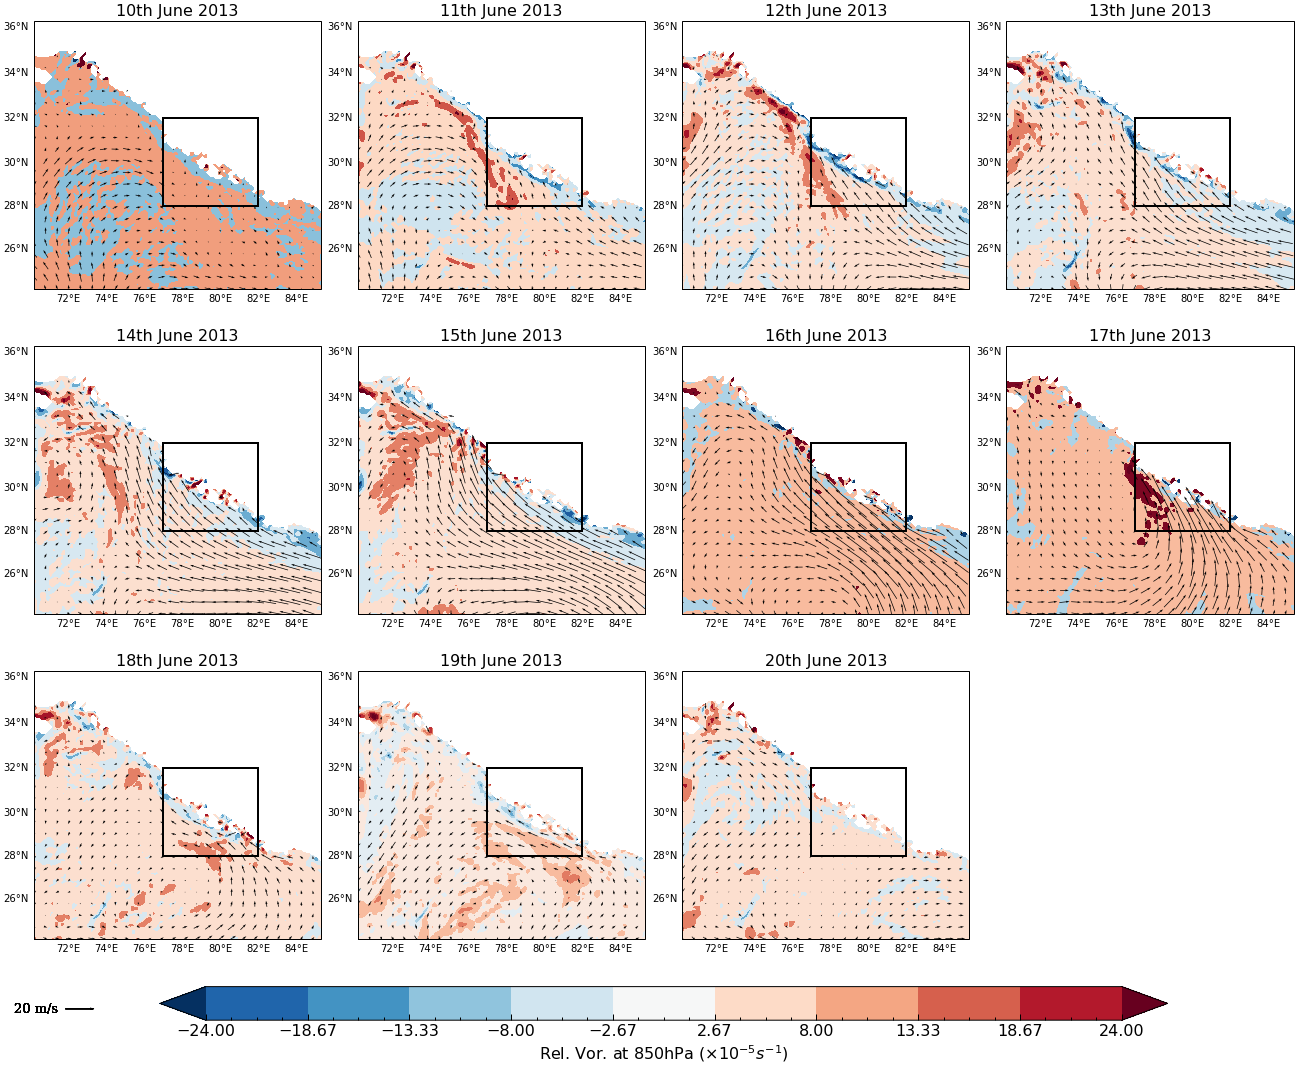

In [48]:
wrfplot.plot_wind(rvo_850_2, u_850_2, v_850_2, cmap='RdBu_r', levels=10, cbar_label=r'Rel. Vor. at 850hPa ($\times 10^{-5} s^{-1}$)', vmin=-24, vmax=24, domain=2)
plt.savefig('./images/rvo850_2.pdf', dpi=300)

#### SFROFF

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

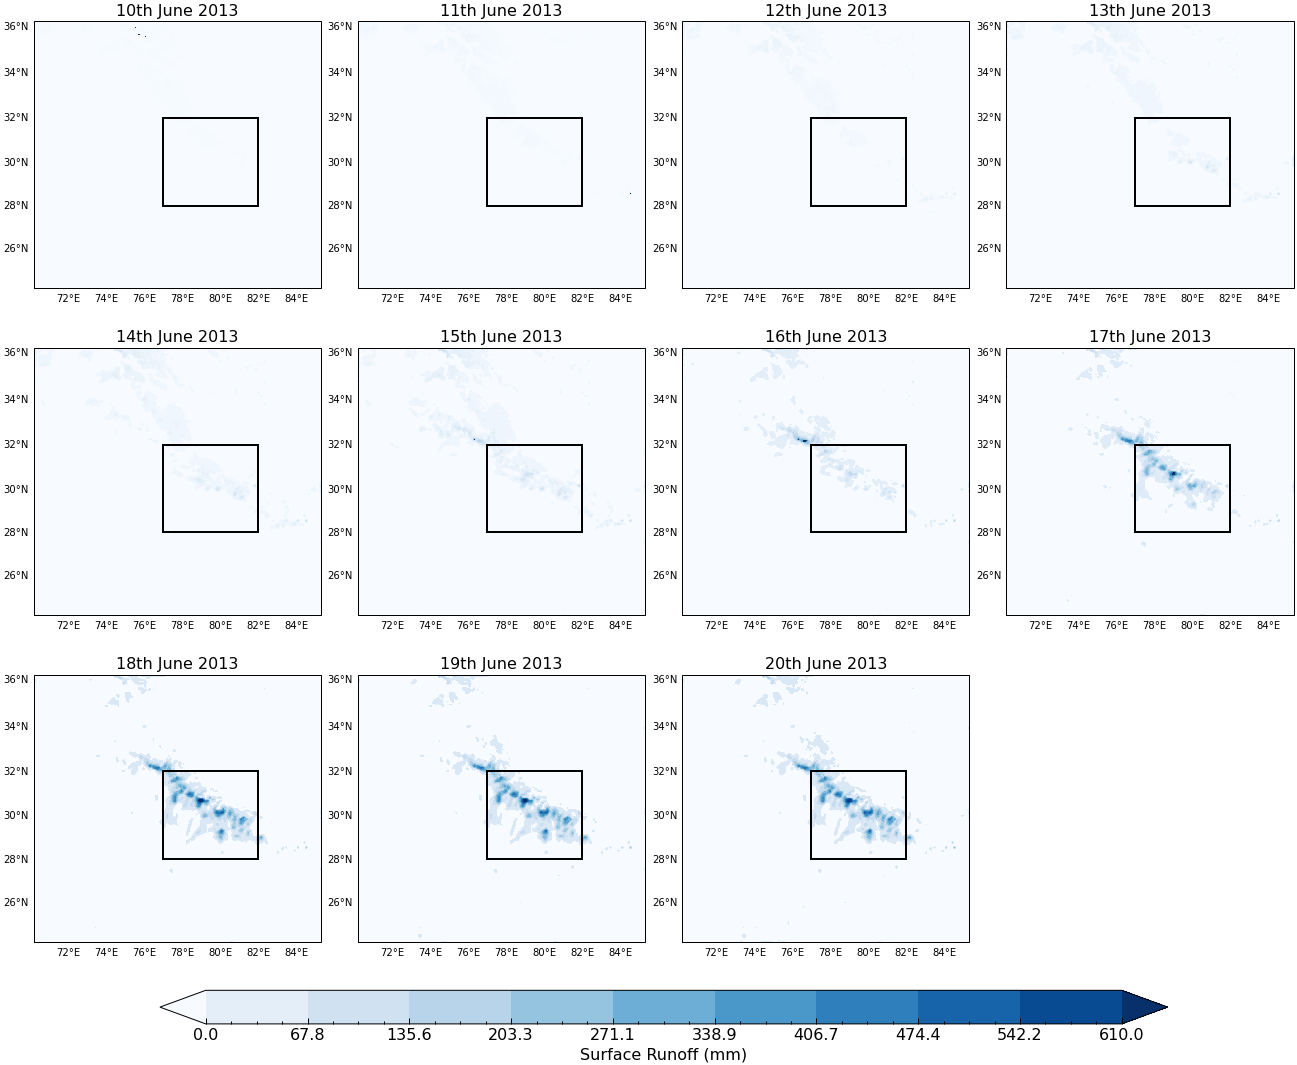

In [62]:
wrfplot.plot_figure(sfroff2, cmap='Blues', levels=10, cbar_label='Surface Runoff (mm)', domain=2)
plt.savefig('./images/sfroff2.pdf')

#### omega

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

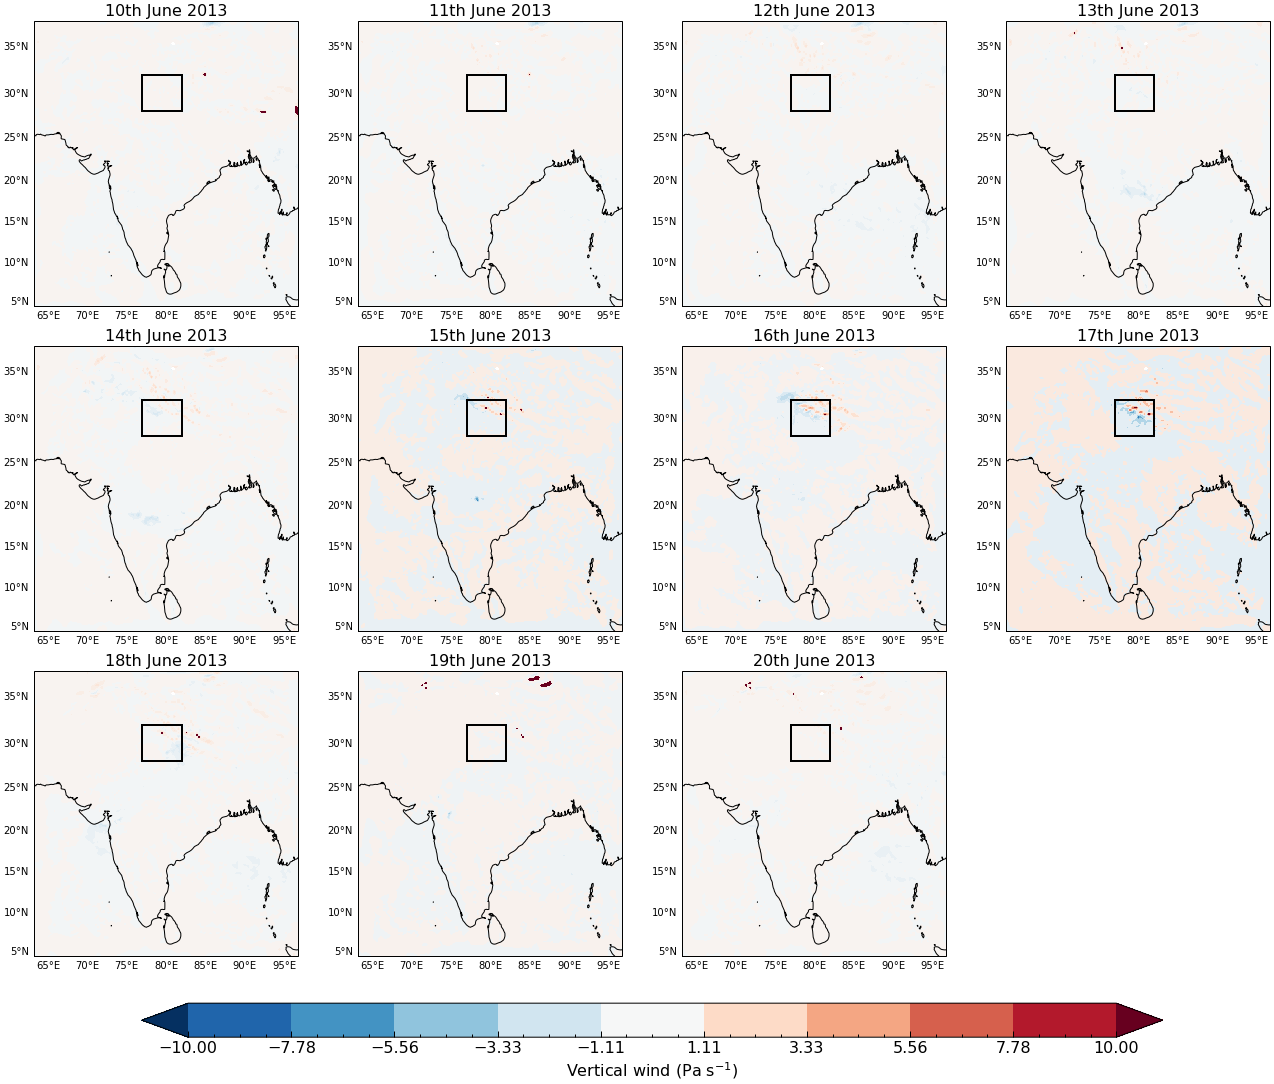

In [53]:
wrfplot.plot_figure(omega_500, cmap='RdBu_r', levels=10, cbar_label='Vertical wind (Pa s$^{-1}$)', domain=1)
plt.savefig('./images/vw1.pdf')

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

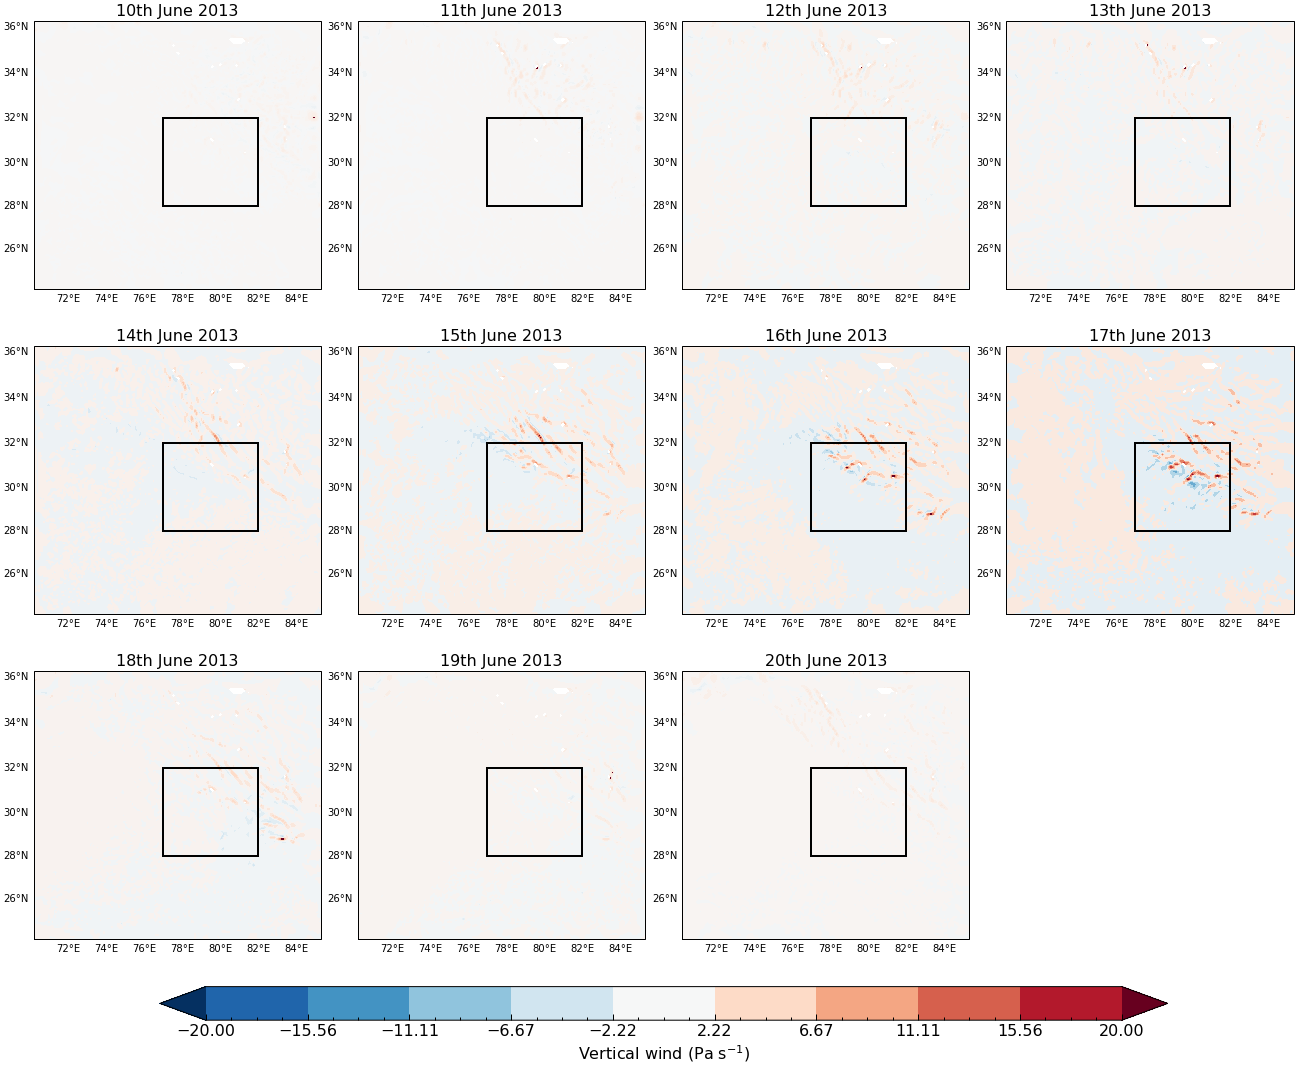

In [54]:
wrfplot.plot_figure(omega_500_2, cmap='RdBu_r', levels=10, cbar_label='Vertical wind (Pa s$^{-1}$)', domain=2)
plt.savefig('./images/vw2.pdf')

#### precipitable water

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

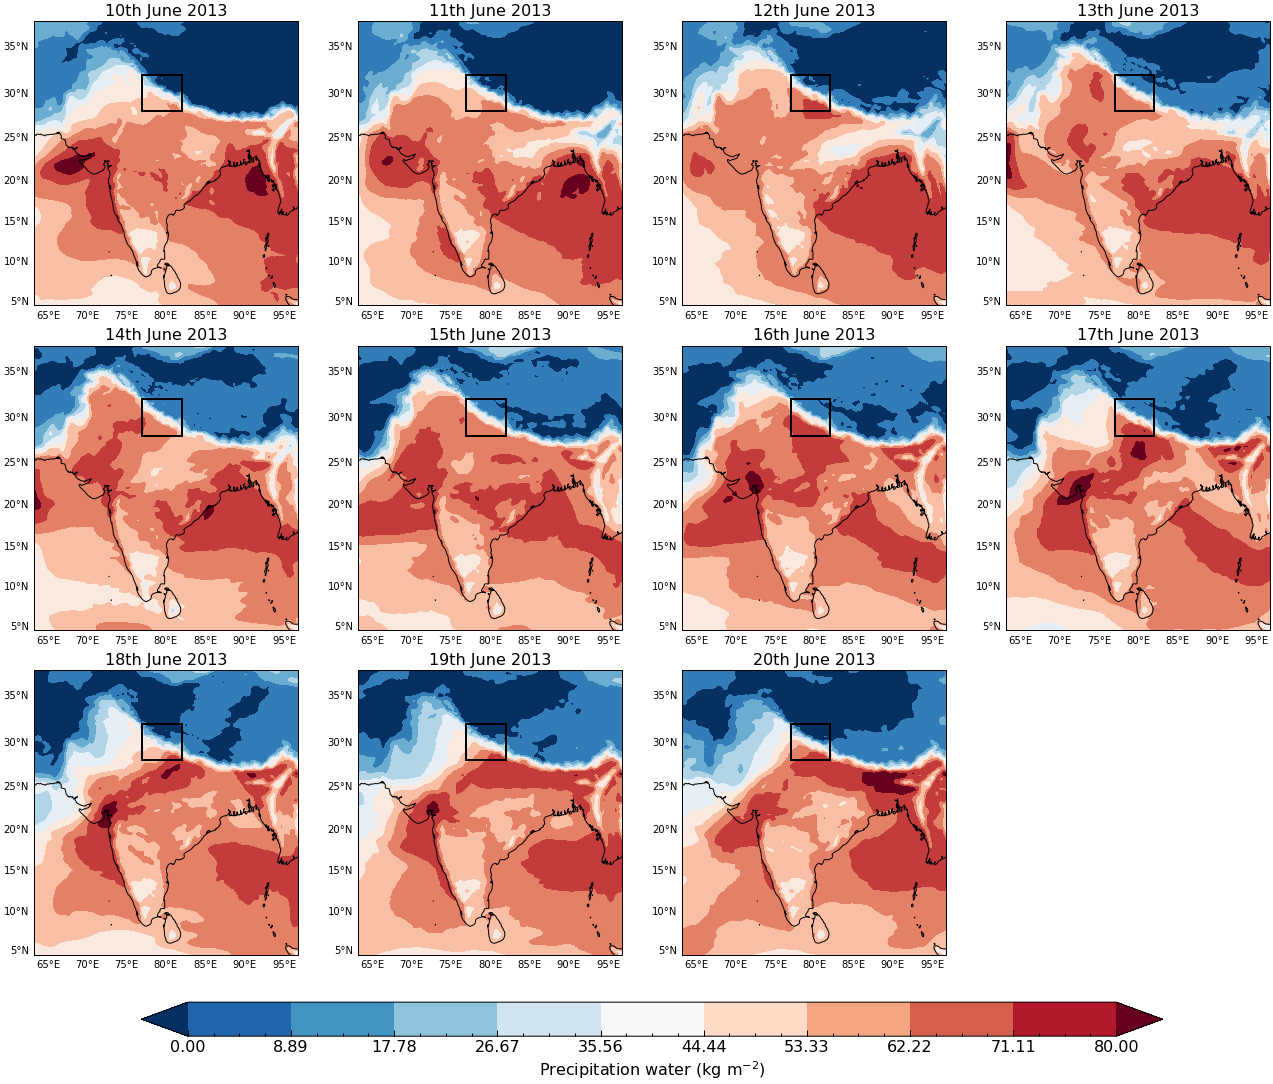

In [55]:
wrfplot.plot_figure(pw, cmap='RdBu_r', levels=10, cbar_label='Precipitation water (kg m$^{-2}$)', domain=1)
plt.savefig('./images/pw1.pdf')

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

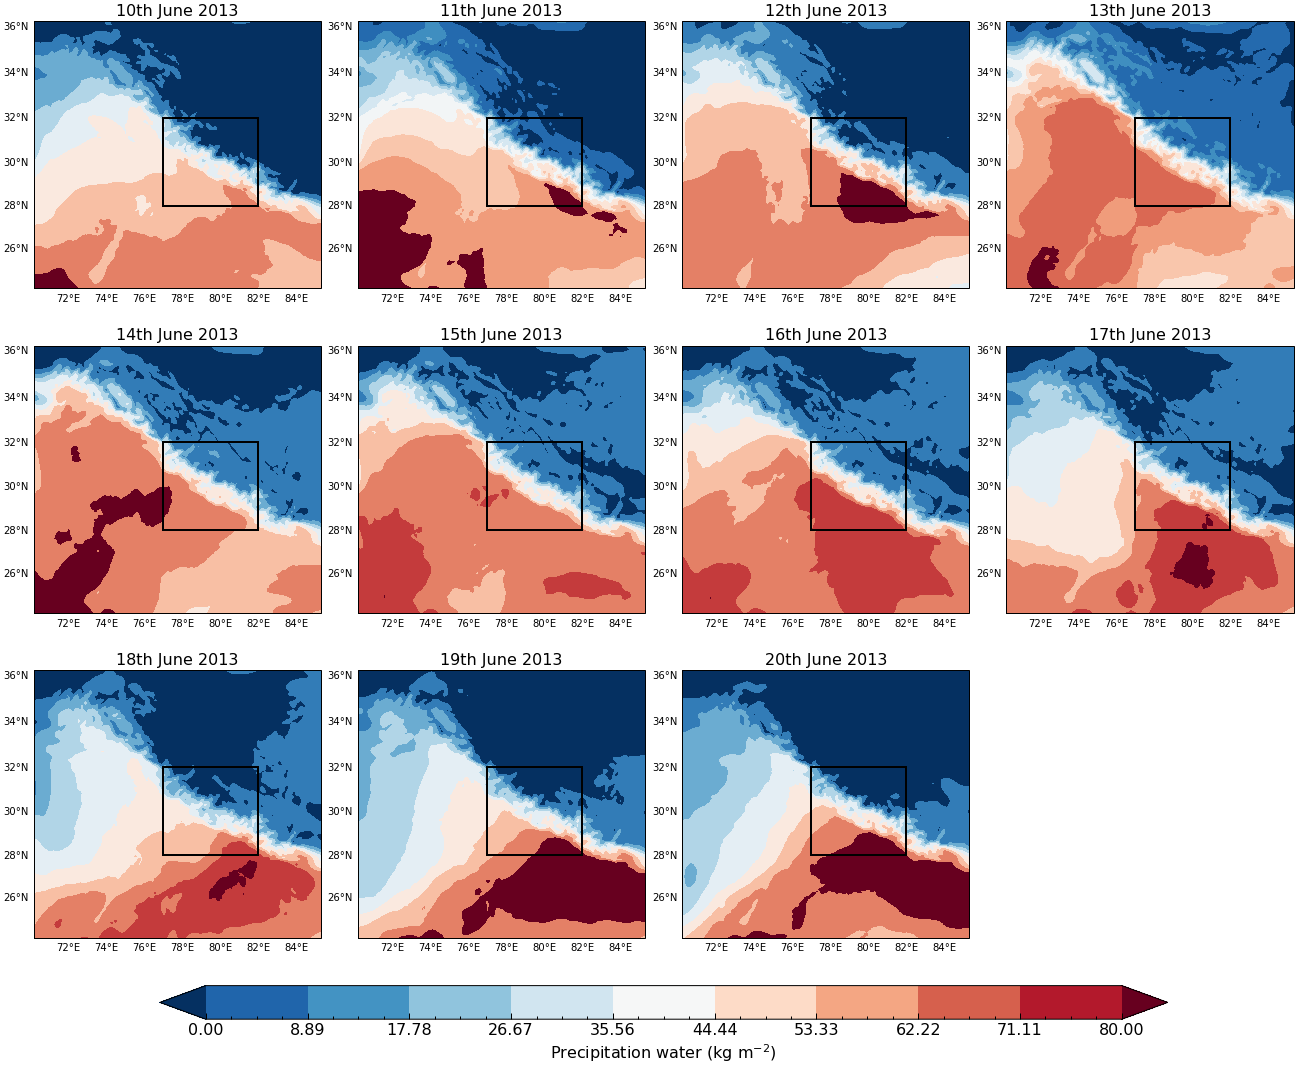

In [56]:
wrfplot.plot_figure(pw2, cmap='RdBu_r', levels=10, cbar_label='Precipitation water (kg m$^{-2}$)', domain=2)
plt.savefig('./images/pw2.pdf')

### Geopotential Height

In [57]:
geopt = getvar(dom1, "geopt", timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
geopt2 = getvar(dom2, "geopt", timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()

In [60]:
geopt_500 = interplevel(geopt, p, 500)
geopt_500_2 = interplevel(geopt2, p2, 500)

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

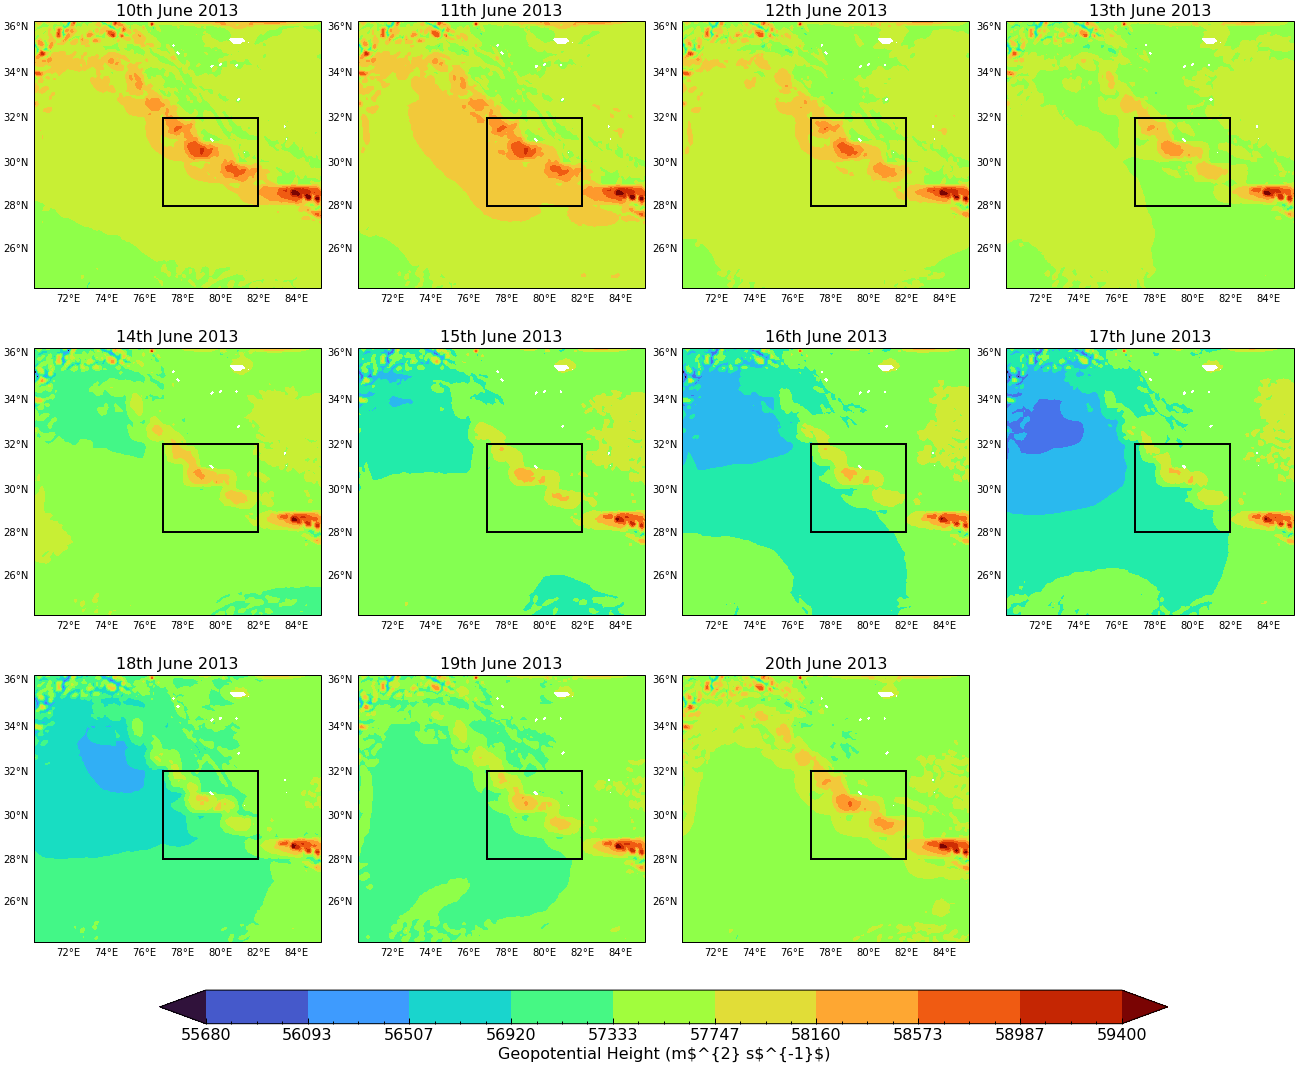

In [64]:
wrfplot.plot_figure(geopt_500_2, cmap='turbo', levels=10, cbar_label=r'Geopotential Height (m$^{2} s$^{-1}$)', domain=2)
plt.savefig('./images/geopt2.pdf')

### Vertical Cross section plots

#### RH

In [ ]:
rh = getvar(dom1, "rh", timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()
rh2 = getvar(dom2, "rh", timeidx=ALL_TIMES, method='cat').resample(Time='D').mean()

In [153]:
omega2.sel(south_north=slice(50,104), west_east=slice(77,136))

<xarray.DataArray 'omega' (Time: 12, bottom_top: 50, south_north: 54, west_east: 59)>
array([[[[ 6.52084053e-02,  7.38408267e-02, -1.72354560e-02, ...,
           9.85520557e-02,  1.23357750e-01,  2.93767124e-01],
         [ 9.13361385e-02,  1.51118174e-01,  1.38393836e-02, ...,
           1.85727194e-01,  4.22209024e-01,  5.35132766e-01],
         [ 6.44576252e-02,  1.07489228e-01,  9.05822963e-05, ...,
           3.59816700e-01,  4.89247710e-01,  3.07058960e-01],
         ...,
         [ 5.30560136e-01,  3.78576040e-01,  9.63870361e-02, ...,
          -3.96934412e-02,  2.41829474e-02, -1.52907059e-01],
         [-3.16196382e-01,  6.60605609e-01,  2.03284070e-01, ...,
          -1.09747492e-01,  1.65936444e-02, -7.39601925e-02],
         [-3.80842716e-01,  1.07060969e+00,  8.51667896e-02, ...,
          -9.51725617e-02, -8.44652019e-03,  2.75696870e-02]],

        [[ 4.08052147e-04,  7.63788521e-02, -7.67525807e-02, ...,
           1.56161919e-01,  1.36052981e-01,  2.55584508e-01],
         [ 1.27325609e-01,  2.97257125e-01,  1.61607210e-02, ...,
           2.91073292e-01,  4.54035074e-01,  6.23419285e-01],
         [ 6.30539283e-02,  1.29114226e-01, -8.83648992e-02, ...,
           3.84801775e-01,  5.15252113e-01,  3.95651668e-01],
...
          -2.73590704e-04, -9.16822319e-05,  1.37715280e-04],
         [ 1.54494157e-03,  1.47937529e-03,  1.42040430e-03, ...,
          -6.78814773e-04, -4.15001268e-04, -8.30249264e-05],
         [ 1.60521222e-03,  1.47713989e-03,  1.24743476e-03, ...,
          -8.86038295e-04, -7.07558007e-04, -3.19664337e-04]],

        [[-1.33082527e-03, -1.50182936e-03, -1.77985721e-03, ...,
          -3.75439209e-04, -1.83310272e-04,  1.15573464e-04],
         [-1.18255452e-03, -1.43778813e-03, -1.71511364e-03, ...,
          -4.08142398e-04, -2.94886762e-04, -7.82389034e-05],
         [-1.14005490e-03, -1.31374865e-03, -1.60954078e-03, ...,
          -4.32344008e-04, -2.56460480e-04, -1.78830785e-04],
         ...,
         [ 2.72415084e-04,  3.17335012e-04,  4.09704982e-04, ...,
           4.84225602e-05,  8.37550397e-05,  9.76204174e-05],
         [ 2.74272054e-04,  3.56457866e-04,  4.24783299e-04, ...,
          -9.44249696e-05,  2.97324414e-06,  7.73741704e-05],
         [ 3.49789567e-04,  4.14760405e-04,  3.63306201e-04, ...,
          -1.22497091e-04, -9.26850989e-05,  4.63774340e-05]]]],
      dtype=float32)
Coordinates:
  * Time     (Time) datetime64[ns] 2013-06-10 2013-06-11 ... 2013-06-21
    XLONG    (south_north, west_east) float32 76.94 77.03 77.12 ... 81.92 82.01
    XLAT     (south_north, west_east) float32 28.01 28.01 28.01 ... 32.02 32.02
Dimensions without coordinates: bottom_top, south_north, west_east

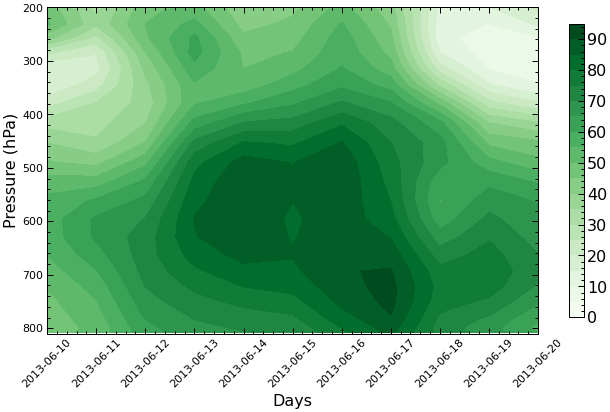

In [71]:
fig = plt.figure(figsize=(11,6))
cf = plt.contourf(to_np(rh2[:-1].coords['Time']), to_np(p2.mean(dim=['south_north', 'west_east'])), to_np(
rh2.sel(south_north=slice(50,104), west_east=slice(77,136))
[:-1].mean(dim=['south_north', 'west_east']).transpose('bottom_top', 'Time')), cmap='Greens', levels=20)
plt.colorbar(cf, ax = plt.gca(), shrink=0.9)
plt.xticks(rotation=45,fontsize=11)
plt.yticks(fontsize=11)
plt.gca().invert_yaxis()
plt.ylim([810, 200])
plt.ylabel('Pressure (hPa)')
plt.xlabel('Days')
plt.savefig('./images/rh2_vertcross.pdf', dpi=300)

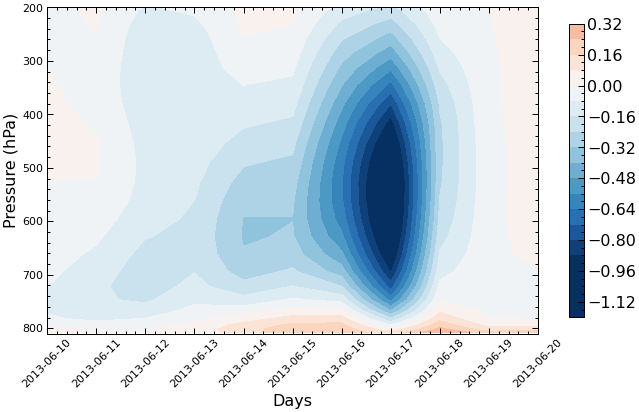

In [174]:
fig = plt.figure(figsize=(11,6))
cf = plt.contourf(to_np(omega2[:-1].coords['Time']), to_np(p2.mean(dim=['south_north', 'west_east'])), to_np(
omega2.sel(south_north=slice(50,104), west_east=slice(77,136))
[:-1].mean(dim=['south_north', 'west_east']).transpose('bottom_top', 'Time')), cmap='RdBu_r', levels=20, vmin=-0.9, vmax=0.9, extend='neither')
plt.colorbar(cf, ax = plt.gca(), shrink=0.9)
plt.xticks(rotation=45,fontsize=11)
plt.yticks(fontsize=11)
plt.gca().invert_yaxis()
plt.ylim([810, 200])
plt.ylabel('Pressure (hPa)')
plt.xlabel('Days')
plt.savefig('./images/omega2_vertcross.pdf', dpi=300)

**RH datewise plots**

In [ ]:
rh_500 = interplevel(rh, p, 500)
rh_500_2 = interplevel(rh2, p2, 500)

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/nkv/.miniconda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDep

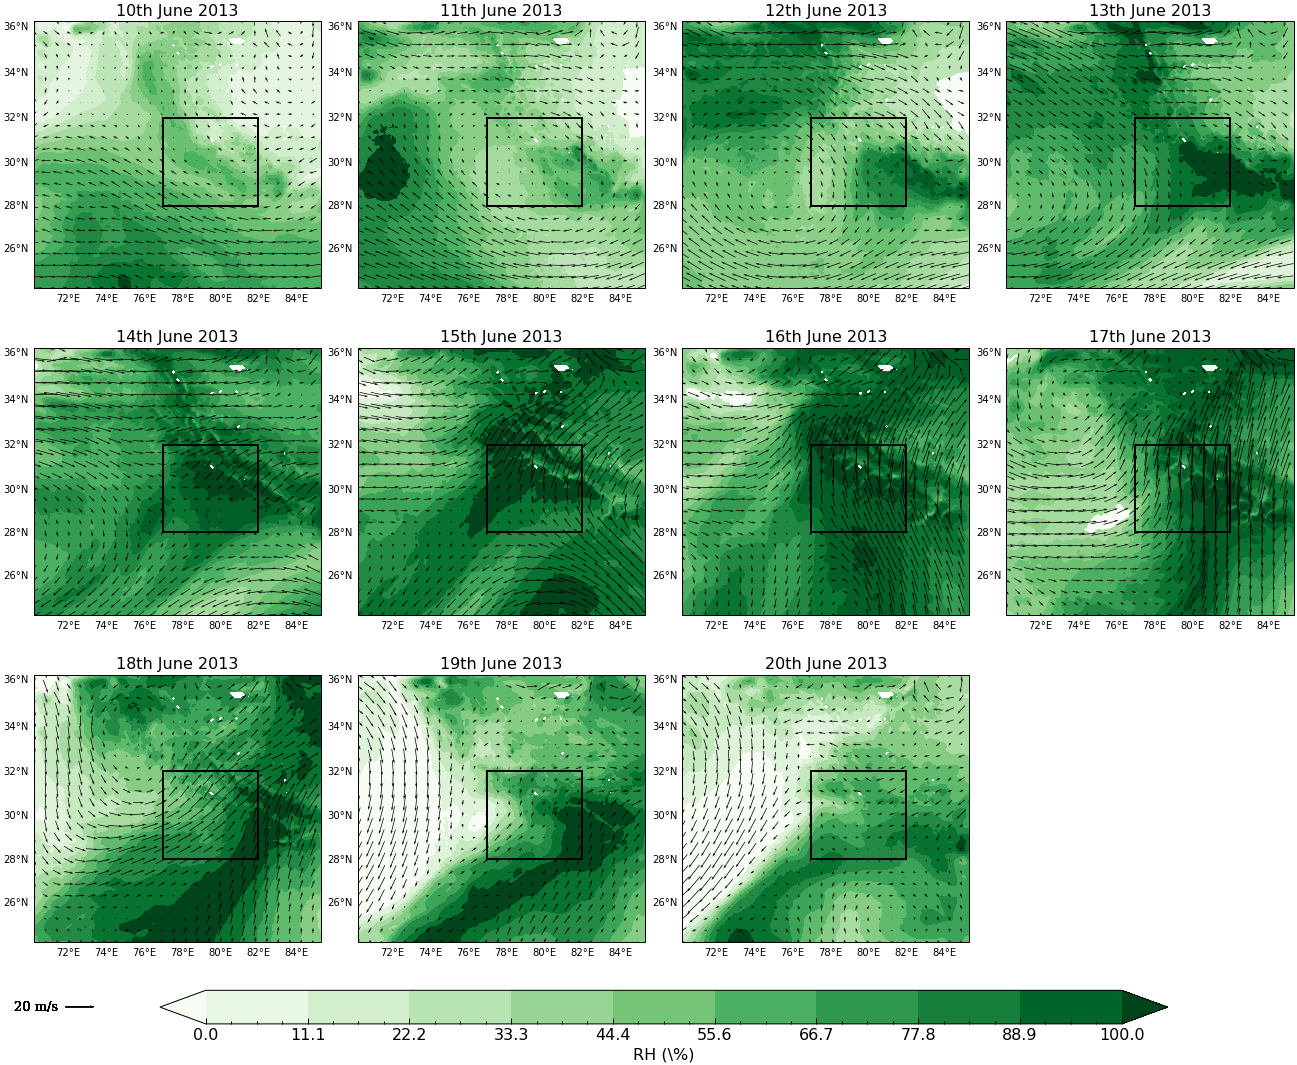

In [94]:
wrfplot.plot_wind(rh_500_2, u_500_2, v_500_2, cmap='Greens', levels=10, cbar_label=r'RH (\%)', domain=2)
plt.savefig('./images/rh500_2.pdf', dpi=300)

## Comparison with other data sets

#### importing them

In [15]:
# gpm = xr.open_mfdataset('./data/gpm/*.nc4')
era = xr.open_dataset('./data/era/download.nc')
# # noaa_ntat = xr.open_dataset('./data/noaa/ulwrf.ntat.gauss.2013.nc')
# noaa_sfc = xr.open_dataset('./data/noaa/ulwrf.sfc.gauss.2013.nc')
# imd = xr.open_dataset('./data/imd/imd_gridded.nc')

In [25]:
# gpm = gpm.transpose('time', 'lat', 'lon')

In [16]:
era = era.resample(time='1D').mean()

In [17]:
era

<xarray.Dataset>
Dimensions:    (time: 11, longitude: 161, latitude: 161, level: 37)
Coordinates:
  * time       (time) datetime64[ns] 2013-06-10 2013-06-11 ... 2013-06-20
  * longitude  (longitude) float32 60.0 60.25 60.5 60.75 ... 99.5 99.75 100.0
  * latitude   (latitude) float32 40.0 39.75 39.5 39.25 ... 0.75 0.5 0.25 0.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
Data variables:
    z          (time, level, latitude, longitude) float32 4.768e+05 ... 945.5
    pv         (time, level, latitude, longitude) float32 0.0038 ... -1.057e-07
    r          (time, level, latitude, longitude) float32 0.0005341 ... 82.63
    q          (time, level, latitude, longitude) float32 3.954e-06 ... 0.01504
    t          (time, level, latitude, longitude) float32 268.2 268.2 ... 299.0
    u          (time, level, latitude, longitude) float32 -34.22 ... 0.2994
    v          (time, level, latitude, longitude) float32 1.193 ... -0.08507
    w          (time, level, latitude, longitude) float32 8.825e-05 ... -0.0984
    vo         (time, level, latitude, longitude) float32 -9.875e-06 ... 3.67...

In [28]:
# imd = imd.sel(TIME = slice("2013-06-10", "2013-06-20"))

In [18]:
climatology = xr.open_dataset('./data/era/climatology.nc')

In [27]:
mean_climate = climatology.sel(time = slice("2013-06-14", "2016-06-18")).mean(dim='time')

In [28]:
mean_weather = era.sel(time = slice("2013-06-14", "2016-06-18")).mean(dim='time')

In [29]:
obs_anomaly = mean_weather = mean_climate

In [30]:
obs_anomaly

<xarray.Dataset>
Dimensions:    (longitude: 161, latitude: 161, level: 3)
Coordinates:
  * longitude  (longitude) float32 60.0 60.25 60.5 60.75 ... 99.5 99.75 100.0
  * latitude   (latitude) float32 40.0 39.75 39.5 39.25 ... 0.75 0.5 0.25 0.0
  * level      (level) int32 200 500 850
Data variables:
    z          (level, latitude, longitude) float32 1.211e+05 ... 1.466e+04
    r          (level, latitude, longitude) float32 3.304 3.249 ... 78.72 78.88
    q          (level, latitude, longitude) float32 6.897e-06 ... 0.01208
    u          (level, latitude, longitude) float32 40.9 40.85 ... 8.049 7.101
    v          (level, latitude, longitude) float32 -7.57 -8.071 ... 0.03201
    w          (level, latitude, longitude) float32 0.0327 0.03156 ... -0.2536
    vo         (level, latitude, longitude) float32 -4.525e-05 ... 6.956e-05

### precipitation comparison GPM, IMD, model

In [227]:
def plot_single(var, day, cmap, levels, cbar_label, domain=1, title = "WRF Sim.", add_colorbar=True):
    if domain == 1:
        ax = plt.axes(projection = wrfplot.cart_proj1)
        wrfplot.plot_background1(ax)
        ax.plot([77,82], [28, 28], color='k', transform=ccrs.PlateCarree())
        ax.plot([77,82], [32, 32], color='k', transform=ccrs.PlateCarree())
        ax.plot([77,77], [28, 32], color='k', transform=ccrs.PlateCarree())
        ax.plot([82,82], [28, 32], color='k', transform=ccrs.PlateCarree())
        ax.scatter(78.1, 30.1, s=20.0, color='k', marker='o', transform=ccrs.PlateCarree())
        cf = ax.contourf(to_np(wrfplot.lons1), to_np(wrfplot.lats1), to_np(var[day]), levels,
                         transform=ccrs.PlateCarree(),
                         cmap=get_cmap(cmap), extend='both')

        if add_colorbar==True:
            cb = plt.colorbar(cf, ax=ax, shrink=.90)
            cb.set_label(cbar_label)
            
        ax.set_title(title)
    if domain == 2:
        ax = plt.axes(projection = wrfplot.cart_proj2)
        wrfplot.plot_background2(ax)
        ax.plot([77,82], [28, 28], color='k', transform=ccrs.PlateCarree())
        ax.plot([77,82], [32, 32], color='k', transform=ccrs.PlateCarree())
        ax.plot([77,77], [28, 32], color='k', transform=ccrs.PlateCarree())
        ax.plot([82,82], [28, 32], color='k', transform=ccrs.PlateCarree())
        ax.scatter(78.1, 30.1, s=40.0, color='k', marker='o', transform=ccrs.PlateCarree())
        cf = ax.contourf(to_np(wrfplot.lons2), to_np(wrfplot.lats2), to_np(var[day]), levels,
                         transform=ccrs.PlateCarree(),
                         cmap=get_cmap(cmap), extend='both')

        if add_colorbar == True:
            cb = plt.colorbar(cf, ax=ax, shrink=.90)
            cb.set_label(cbar_label)
        ax.set_title(title)
    else:
        print("wrong value of domain input")

In [274]:
levels = np.arange(15,240,30)
levels

array([ 15,  45,  75, 105, 135, 165, 195, 225])

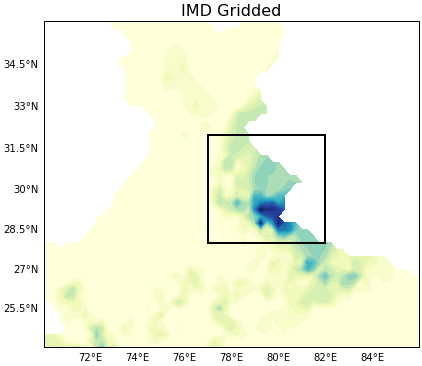

In [275]:
ax = plt.axes(projection = wrfplot.cart_proj2)
ax.add_feature(cfeature.COASTLINE)
gridliner = ax.gridlines(draw_labels=True, linewidth=1.0, color="gray", linestyle="--", alpha=0.5)
gridliner.top_labels=False
gridliner.right_labels=False
gridliner.xlines=False
ax.plot([77,82], [28, 28], color='k', transform=ccrs.PlateCarree())
ax.plot([77,82], [32, 32], color='k', transform=ccrs.PlateCarree())
ax.plot([77,77], [28, 32], color='k', transform=ccrs.PlateCarree())
ax.plot([82,82], [28, 32], color='k', transform=ccrs.PlateCarree())
gridliner.ylines=False
imd.sel(LATITUDE = slice(24,36), LONGITUDE=slice(70,86)).RAINFALL[8].plot.contourf(levels=20, transform=ccrs.PlateCarree(), vmin=15, vmax=225, extend='both', add_colorbar=False)
ax.set_title("IMD Gridded")
# ax.scatter(78.1, 30.1, s=20.0, color='k', marker='o', transform=ccrs.PlateCarree())
plt.savefig('./images/comparison/imd_precip8.png', dpi=300)

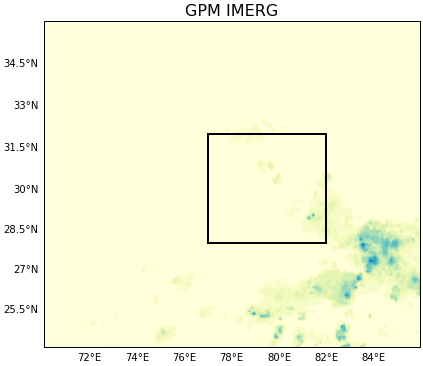

In [276]:
ax = plt.axes(projection = wrfplot.cart_proj2)
ax.add_feature(cfeature.COASTLINE)
gridliner = ax.gridlines(draw_labels=True, linewidth=1.0, color="gray", linestyle="--", alpha=0.5)
gridliner.top_labels=False
gridliner.right_labels=False
gridliner.xlines=False
gridliner.ylines=False
gpm.sel(lat = slice(24,36), lon=slice(70,86)).precipitationCal[8].plot.contourf(levels=20, transform=ccrs.PlateCarree(), vmin=15, vmax=225, extend='both', add_colorbar=False)
ax.plot([77,82], [28, 28], color='k', transform=ccrs.PlateCarree())
ax.plot([77,82], [32, 32], color='k', transform=ccrs.PlateCarree())
ax.plot([77,77], [28, 32], color='k', transform=ccrs.PlateCarree())
ax.plot([82,82], [28, 32], color='k', transform=ccrs.PlateCarree())
ax.set_title("GPM IMERG")
# ax.scatter(78.1, 30.1, s=20.0, color='k', marker='o', transform=ccrs.PlateCarree())
plt.savefig('./images/comparison/gpm_precip8.png', dpi=300)

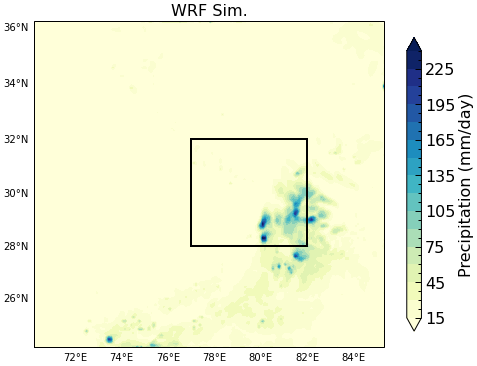

In [273]:
plot_single(precip_rate2, day=8, cmap="YlGnBu", cbar_label="Precipitation (mm/day)", domain=2, levels=20, add_colorbar=True)
ax.plot([77,82], [28, 28], color='k', transform=ccrs.PlateCarree())
ax.plot([77,82], [32, 32], color='k', transform=ccrs.PlateCarree())
ax.plot([77,77], [28, 32], color='k', transform=ccrs.PlateCarree())
ax.plot([82,82], [28, 32], color='k', transform=ccrs.PlateCarree())
# ax.scatter(78.1, 30.1, s=20.0, color='k', marker='o', transform=ccrs.PlateCarree())
plt.savefig('./images/comparison/wrf_precip8.png', dpi=300)

In [33]:
era["wspd"] = np.sqrt(era.u**2 + era.v**2)

In [ ]:
ax = plt.axes(projection = wrfplot.cart_proj1)
ax.add_feature(cfeature.COASTLINE)
gridliner = ax.gridlines(draw_labels=True, linewidth=1.0, color="gray", linestyle="--", alpha=0.5)
gridliner.top_labels=False
gridliner.right_labels=False
gridliner.xlines=False
gridliner.ylines=False
ax.plot([77,82], [28, 28], color='k', transform=ccrs.PlateCarree())
ax.plot([77,82], [32, 32], color='k', transform=ccrs.PlateCarree())
ax.plot([77,77], [28, 32], color='k', transform=ccrs.PlateCarree())
ax.plot([82,82], [28, 32], color='k', transform=ccrs.PlateCarree())
# gpm.sel(lat = slice(24,36), lon=slice(70,86)).precipitationCal[8].plot.contourf(levels=20, transform=ccrs.PlateCarree(), vmin=15, vmax=225, extend='both', add_colorbar=False)
era.sel(time = "2013-06-17", level = 500).r.plot.contourf(levels=20, extend='both', cbar_kwargs = {'shrink':0.9}, transform=ccrs.PlateCarree(), cmap="Greens")
q = era.sel(time = "2013-06-17", level = 500, latitude=slice(0,40,5), longitude=slice(60,100,5)).plot.quiver('longitude', 'latitude', 'u', 'v', pivot='middle', scale=35, units='width', transform=ccrs.PlateCarree())
# q = ax.quiver(np.mesuv0.coords['lon'], uv0.coords['lat'], uv0.u, uv0.v)
# qk = ax.quiverkey(q, 0.001, 0.0005, 3, r'3 $ms^{-1}$$', labelpos='E')
ax.set_title("ERA5")

In [ ]:
ax = plt.axes(projection = wrfplot.cart_proj1)
ax.add_feature(cfeature.COASTLINE)
gridliner = ax.gridlines(draw_labels=True, linewidth=1.0, color="gray", linestyle="--", alpha=0.5)
gridliner.top_labels=False
gridliner.right_labels=False
gridliner.xlines=False
gridliner.ylines=False
ax.plot([77,82], [28, 28], color='k', transform=ccrs.PlateCarree())
ax.plot([77,82], [32, 32], color='k', transform=ccrs.PlateCarree())
ax.plot([77,77], [28, 32], color='k', transform=ccrs.PlateCarree())
ax.plot([82,82], [28, 32], color='k', transform=ccrs.PlateCarree())
ax.contourf(to_np(wrfplot.lons1), to_np(wrfplot.lats1), to_np(rh_500[7]), 20, transform=ccrs.PlateCarree(), cmap="Greens", extend='both')
# q = uv0.plot.quiver('lon', 'lat', 'u', 'v', pivot='middle', scale=35, units='width')
# q = ax.quiver(np.mesuv0.coords['lon'], uv0.coords['lat'], uv0.u, uv0.v)
# qk = ax.quiverkey(q, 0.001, 0.0005, 3, r'3 $ms^{-1}$$', labelpos='E')
ax.set_title("WRF Sim.")

### Wind anomaly